# lec18. ARIMA - 공공데이터포털
* daily_seoul_air_cond

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt


import warnings
warnings.filterwarnings(action='ignore')

#-------------------- 차트 관련 속성 (한글처리, 그리드) -----------
#plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set()

#-------------------- 주피터 , 출력결과 넓이 늘리기 ---------------
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important;}</style>"))
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', None)

In [3]:
df = pd.read_csv("./lec18_daily_seoul_air_cond_2020.04.csv", parse_dates=['측정일시']) 

In [4]:
df.columns   # '측정일시' '측정소명' '미세먼지 1시간(㎍/㎥)',

Index(['측정일시', '권역코드', '권역명', '측정소코드', '측정소명', '미세먼지 1시간(㎍/㎥)',
       '미세먼지 24시간(㎍/㎥)', '초미세먼지(㎍/㎥)', '오존(ppm)', '이산화질소농도(ppm)',
       '일산화탄소농도(ppm)', '아황산가스농도(ppm)'],
      dtype='object')

In [5]:
print(df.shape)
print(df.info())
df.head()


(18000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   측정일시            18000 non-null  datetime64[ns]
 1   권역코드            18000 non-null  int64         
 2   권역명             18000 non-null  object        
 3   측정소코드           18000 non-null  int64         
 4   측정소명            18000 non-null  object        
 5   미세먼지 1시간(㎍/㎥)   18000 non-null  int64         
 6   미세먼지 24시간(㎍/㎥)  18000 non-null  int64         
 7   초미세먼지(㎍/㎥)      18000 non-null  int64         
 8   오존(ppm)         18000 non-null  float64       
 9   이산화질소농도(ppm)    18000 non-null  float64       
 10  일산화탄소농도(ppm)    18000 non-null  float64       
 11  아황산가스농도(ppm)    18000 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(5), object(2)
memory usage: 1.6+ MB
None


,측정일시,권역코드,권역명,측정소코드,측정소명,미세먼지 1시간(㎍/㎥),미세먼지 24시간(㎍/㎥),초미세먼지(㎍/㎥),오존(ppm),이산화질소농도(ppm),일산화탄소농도(ppm),아황산가스농도(ppm)
0,2020-04-30 23:00:00,100,도심권,111123,종로구,40,43,21,0.036,0.008,0.3,0.003
1,2020-04-30 23:00:00,100,도심권,111121,중구,31,41,22,0.037,0.010,0.3,0.003
2,2020-04-30 23:00:00,100,도심권,111131,용산구,41,40,21,0.035,0.011,0.3,0.002
3,2020-04-30 23:00:00,101,서북권,111181,은평구,32,37,20,0.053,0.005,0.3,0.003
4,2020-04-30 23:00:00,101,서북권,111201,마포구,34,34,21,0.043,0.009,0.3,0.002


In [6]:
df = df[['측정일시', '측정소명','미세먼지 1시간(㎍/㎥)','미세먼지 24시간(㎍/㎥)']].copy()
df.head(2)

,측정일시,측정소명,미세먼지 1시간(㎍/㎥),미세먼지 24시간(㎍/㎥)
0,2020-04-30 23:00:00,종로구,40,43
1,2020-04-30 23:00:00,중구,31,41


# EDA

## 측정소별로 미세먼지 평균

In [23]:
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False # - 기호 안 깨지게

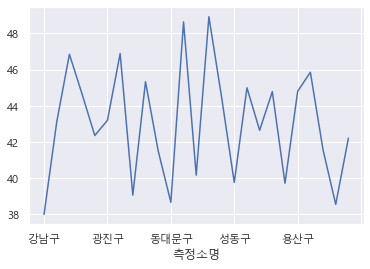

In [35]:
df.groupby(by='측정소명')['미세먼지 1시간(㎍/㎥)'].mean().plot()
plt.show()

### 강사님

<AxesSubplot:xlabel='측정소명'>

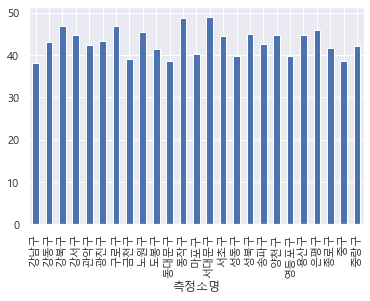

In [39]:
df.groupby(by='측정소명')['미세먼지 1시간(㎍/㎥)'].mean().plot(kind='bar')

<AxesSubplot:xlabel='측정소명', ylabel='미세먼지 1시간(㎍/㎥)'>

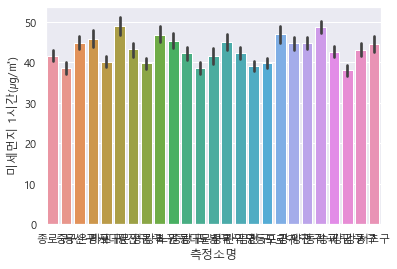

In [40]:
sns.barplot(x='측정소명', y='미세먼지 1시간(㎍/㎥)', data=df)

# ARIMA 모델을 위한 데이터셋 준비

## (방법1) df[조건].copy

In [45]:
dfg=df[df['측정소명']=='중구'][['측정일시','미세먼지 1시간(㎍/㎥)']].copy()

In [46]:
dfs=df[df['측정소명']=='서대문구'][['측정일시','미세먼지 1시간(㎍/㎥)']].copy()

In [47]:
dfg.head()

,측정일시,미세먼지 1시간(㎍/㎥)
1,2020-04-30 23:00:00,31
26,2020-04-30 22:00:00,35
52,2020-04-30 21:00:00,46
77,2020-04-30 20:00:00,65
100,2020-04-30 19:00:00,47


In [48]:
dfs.head()

,측정일시,미세먼지 1시간(㎍/㎥)
5,2020-04-30 23:00:00,36
29,2020-04-30 22:00:00,40
55,2020-04-30 21:00:00,39
78,2020-04-30 20:00:00,35
103,2020-04-30 19:00:00,33


## (방법2) 피벗 이용 (가로축, 세로축 변경)

In [53]:
# 두 개 동시 그룹바이
# 복합인덱스: 측정일시, 측정소명
df.groupby(by=['측정일시','측정소명'])['미세먼지 1시간(㎍/㎥)'].mean()

# 보기 불편 -> 일시가 인덱스, 측정소명이 가로로 들어가는 형태가 편하지 않겠나

측정일시                 측정소명
2020-04-01 00:00:00  강남구     44.0
                     강동구     51.0
                     강북구     56.0
                     강서구     52.0
                     관악구     45.0
                             ... 
2020-04-30 23:00:00  용산구     41.0
                     은평구     32.0
                     종로구     40.0
                     중구      31.0
                     중랑구     40.0
Name: 미세먼지 1시간(㎍/㎥), Length: 18000, dtype: float64

In [56]:
pvdf=df.pivot_table(values='미세먼지 1시간(㎍/㎥)',
                   index='측정일시',
                   columns='측정소명',
                   aggfunc='mean' )
pvdf.head()

측정소명,강남구,강동구,강북구,강서구,관악구,광진구,구로구,금천구,노원구,도봉구,동대문구,동작구,마포구,서대문구,서초구,성동구,성북구,송파구,양천구,영등포구,용산구,은평구,종로구,중구,중랑구
측정일시,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-01 00:00:00,44,51,56,52,45,54,62,39,56,57,44,51,48,55,55,45,48,51,52,46,58,54,46,44,51
2020-04-01 01:00:00,49,56,69,51,52,54,64,43,73,64,46,57,52,61,59,46,55,55,52,49,59,55,47,44,53
2020-04-01 02:00:00,50,55,90,59,57,61,79,52,91,82,51,68,51,61,68,52,90,55,60,51,60,52,53,47,64
2020-04-01 03:00:00,54,74,98,75,65,97,90,66,97,90,67,77,56,88,74,63,84,61,73,56,62,57,59,56,90
2020-04-01 04:00:00,58,81,97,80,67,96,95,69,93,87,74,83,60,83,83,60,84,61,80,63,65,70,66,71,88


In [58]:
pvdf['중구'].head() # 훨씬 편하다

측정일시
2020-04-01 00:00:00    44
2020-04-01 01:00:00    44
2020-04-01 02:00:00    47
2020-04-01 03:00:00    56
2020-04-01 04:00:00    71
Name: 중구, dtype: int64

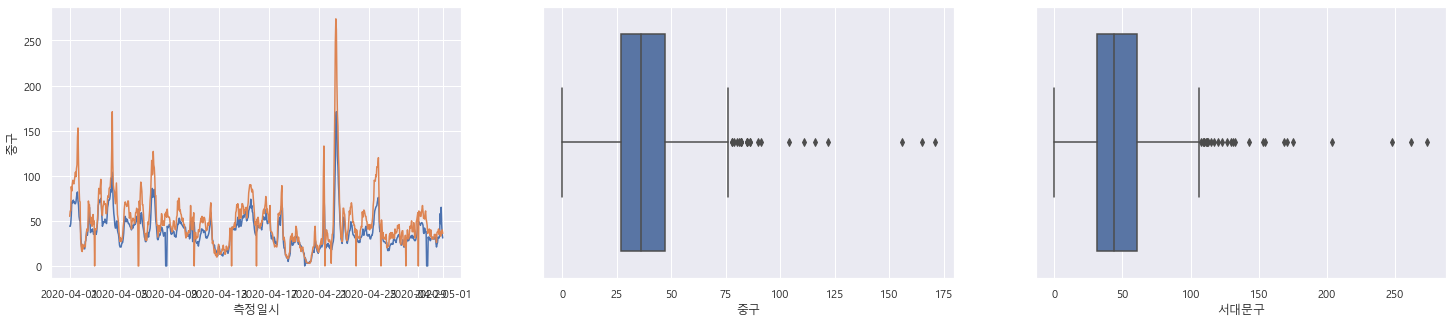

In [90]:
# 두 권역 차이 -> line plot
# 두 권역 이상치 확인 -> box plot (각각)

f, axs=plt.subplots(1,3, figsize=(25,5))


sns.lineplot(x=pvdf.index, y=pvdf['중구'], ax=axs[0])
sns.lineplot(x=pvdf.index, y=pvdf['서대문구'], ax=axs[0])

sns.boxplot(pvdf['중구'], ax=axs[1])

sns.boxplot(pvdf['서대문구'], ax=axs[2]) # 이상치 보이긴 하지만 단순히 drop하면 안 된다. 시계열은 데이터 중간에 끊기면 안 된다.

plt.show()

# pvdf[['중구']]

# 모델 학습&평가

In [94]:
# 긴 버전 seoul_v01이나 lec17_arima에
# ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# from statsmodels.tsa.arima.model import ARIMA  # statsmodel version 1.12
from statsmodels.tsa.arima_model import ARIMA # statsmodel version 1.10.2

# model = ARIMA(pvdf['중구'], order, freq='H')
# fit_res=model.fit()
# print(fit_res.summary())

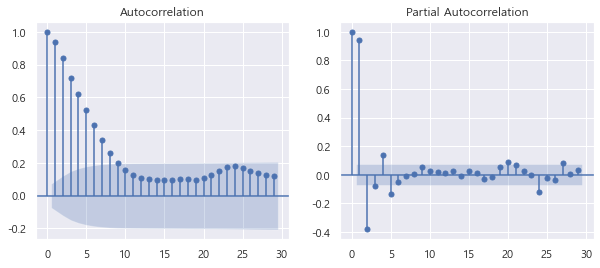

In [95]:
p, axes = plt.subplots(1,2,figsize=(10,4))
plot_acf(pvdf['중구'], ax=axes[0])
plot_pacf(pvdf['중구'], ax=axes[1])
plt.show()

* AR 모형 - 2차분 ~ 5차분

In [100]:
model = ARIMA(pvdf['중구'].iloc[2:], order=(2,2,0), freq='H')
fit_res=model.fit(trned='nc')
print(fit_res.summary())

                             ARIMA Model Results                              
Dep. Variable:                  D2.중구   No. Observations:                  716
Model:                 ARIMA(2, 2, 0)   Log Likelihood               -2438.212
Method:                       css-mle   S.D. of innovations              7.288
Date:                Mon, 07 Feb 2022   AIC                           4884.424
Time:                        18:14:07   BIC                           4902.719
Sample:                    04-01-2020   HQIC                          4891.488
                         - 04-30-2020                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0233      0.184     -0.127      0.899      -0.384       0.337
ar.L1.D2.중구    -0.3806      0.037    -10.233      0.000      -0.454      -0.308
ar.L2.D2.중구    -0.1024      0.037     -2.744    

In [ ]:
# 강사님
# train = pvdf['중구'].iloc[:-5] 
# test  = pvdf['중구'].iloc[-5:]

model = ARIMA(pvdf['중구'], order=(2,2,0), freq='H')
fit_res = model.fit(trend='nc')
# pred = fit_res.forecast(steps=3)  # 4,145.1
pred = fit_res.predict(start=2, end=30, typ='levels', dynamic=False)

print(pred[:5])
print(pvdf['중구'].dropna()[2:7])